# online nets

Deep learning is powerful but computationally expensive, frequently requiring massive compute budgets. In persuit of cost-effective-yet-powerful AI, this work explores and evaluates a heuristic which should lend to more-efficient use of data through online learning.

Goal: evaluate a deep learning alternative capable of true online learning. Solution requirements:

1. catastrophic forgetting should be impossible;
2. all data is integrated into sufficient statistics of fixed dimension;
3. and our solution should have predictive power comparable to deep learning.

## modeling strategy

We will not attempt to derive sufficient statistics for an entire deep net, but instead leverage well-known sufficient statistics for least squares models, 
so will have sufficient statistics per deep net layer. If this can be empirically shown effective, we'll build-out the theory afterwards. 


# model code definitions

In [46]:
import torch

class DenseLayer:
    '''
    '''
    pass

class OnlineNetBase:
    '''
    A low-level class defining a recursive neural net employing
    a hueristic to enable true online learning. No activation 
    functions are used. Latent variables are not abstracted-away. 
    Only the essential math is defined as `y = x a^{-1} b`. The 
    first `p-l` dimensions of `x` are assumed observed, and latent
    thereafter. 
    '''
    def __init__(self, p, l, regularizer=0.001):
        '''
        Initialize an Online Net
        inputs:
         - p: input and output vector dimension
         - l: number of latent variables, `<p`
         - regularizer: L2 regualarization value, `>0`
        '''
        ## verify inputs 
        if type(p) != int:
            raise ValueError('`p` must be an int!')
        if type(l) != int:
            raise ValueError('`l` must be an int!')
        if type(regularizer) not in [int, float]:
            raise ValueError('`regularizer` must be an int or float!') 
        if type(regularizer) == int:
            regularizer = float(regularizer)
        if p <= 0:
            raise ValueError('`p` must be `>0`!') 
        if l < 0 or l > p:
            raise ValueError('`l` must satisfy `0 <= l <= p`!')
        if regularizer <= .0:
            raise ValueError('`regularizer` must be `>0`!')
        ## store init variables 
        self.p = p 
        self.l = l 
        self.regularizer = regularizer
        ## construct initial estimates 
        regularizer_vec = torch.tensor([regularizer]*p) 
        inv_regularizer_vec = torch.tensor([1./regularizer]*p) 
        self.a = torch.diag(regularizer_vec)
        self.b = torch.diag(regularizer_vec)
        self.inv_a = torch.diag(inv_regularizer_vec)
        self.inv_b = torch.diag(inv_regularizer_vec)
        pass 
    
    def predict(self, x):
        '''
        Predict y vector from an x vector
        inputs:
         - x: torch.Tensor of shape `[p]`
        outputs:
         - y: torch.Tensor of shape `[p]`
        '''
        ## verify inputs 
        if type(x) != torch.Tensor:
            raise ValueError('`x` must be of type `torch.Tensor`!') 
        if len(x.shape) != 1:
            raise ValueError('`x` must satisfy `len(x.shape) == 1`!') 
        if x.shape[0] != self.p:
            raise ValueError('`x` must satisfy `x.shape[0] == p`!') 
        ## calculate output
        y = x.reshape([1, self.p])
        y = torch.matmul(y, self.inv_a) 
        y = torch.matmul(y, self.b) 
        return y.reshape([self.p]) 
    
    def fit(self, x, y):
        '''
        Update the model to a new observation `y`.
        inputs:
         - x: torch.Tensor of shape `[p]` 
         - y: torch.Tensor of shape `[p]`
        '''
        ## verify inputs 
        if type(x) != torch.Tensor:
            raise ValueError('`x` must be of type `torch.Tensor`!') 
        if len(x.shape) != 1:
            raise ValueError('`x` must satisfy `len(x.shape) == 1`!') 
        if x.shape[0] != self.p:
            raise ValueError('`x` must satisfy `x.shape[0] == p`!') 
        if type(y) != torch.Tensor:
            raise ValueError('`y` must satisfy `type(y) == torch.Tensor`!') 
        if len(y.shape) != 1:
            raise ValueError('`y` must satisfy `len(y.shape) == 1`!') 
        if y.shape[0] != self.p:
            raise ValueError('`y` must satisfy `y.shape[0] == self.p`!') 
        ## update model 
        x_row = x.reshape([1, self.p]) 
        y_row = y.reshape([1, self.p]) 
        xTx = x_row.transpose(0,1).matmul(x_row) 
        xTy = x_row.transpose(0,1).matmul(y_row) 
        self.a = self.a + xTx 
        self.b = self.b + xTy 
        self.inv_a = self.inv_a - (self.inv_a.matmul(xTx).matmul(self.inv_a))/(1. + x_row.matmul(self.inv_a).matmul(x_row.transpose(0,1)))
        self.inv_b = self.inv_b - (self.inv_b.matmul(xTy).matmul(self.inv_b))/(1. + y_row.matmul(self.inv_b).matmul(x_row.transpose(0,1)))
        #print(f'DEBUG  4 a b inv_a inv_b sums: {self.a.sum()} {self.b.sum()} {self.inv_a.sum()} {self.inv_b.sum()}') 
        #print(f'DEBUG 5 inv_b num.sum denom: {(self.inv_b.matmul(xTy).matmul(self.inv_b)).sum()} {(1. + y_row.matmul(self.inv_b).matmul(x_row.transpose(0,1)))}')
        pass 
    
    def build_y(self, x, y_pred, y_obs):
        '''
        Applies the heuristic, updating latent values in `y`. 
        inputs:
         - x: torch.Tensor of shape `[p]` 
         - y_pred: torch.Tensor of shape `[p]`, output of `predict`
         - y_obs: torch.Tensor of shape `[p-l]`, observed portion of our next process step.
        outputs:
         - y_updated: torch.Tensor of shape `[p]`
        '''
        ## verify inputs 
        if type(x) != torch.Tensor:
            raise ValueError('`x` must be of type `torch.Tensor`!') 
        if len(x.shape) != 1:
            raise ValueError('`x` must satisfy `len(x.shape) == 1`!') 
        if x.shape[0] != self.p:
            raise ValueError('`x` must satisfy `x.shape[0] == p`!') 
        if type(y_pred) != torch.Tensor:
            raise ValueError('`y_pred` must satisfy `type(y_pred) == torch.Tensor`!') 
        if len(y_pred.shape) != 1:
            raise ValueError('`y_pred` must satisfy `len(y_pred.shape) == 1`!') 
        if y_pred.shape[0] != self.p:
            raise ValueError('`y_pred` must satisfy `y_pred.shape[0] == self.p`!') 
        if type(y_obs) != torch.Tensor:
            raise ValueError('`y_obs` must satisfy `type(y_obs) == torch.Tensor`!') 
        if len(y_obs.shape) != 1:
            raise ValueError('`y_obs` must satisfy `len(y_obs.shape) == 1`!') 
        if y_obs.shape[0] != self.p - self.l:
            raise ValueError('`y_obs` must satisfy `y_obs.shape[0] == self.p` - self.l!') 
        ## apply heuristic 
        x_pred = y_pred.reshape([1, self.p]).matmul(self.inv_b).matmul(self.a).reshape([self.p]) 
        #print(f'DEBUG 2 x_pred.sum(): {x_pred.sum()}') 
        #y_updated_observed = y_pred[:(self.p - self.l)] 
        y_updated_latent = x_pred[(self.p - self.l):] 
        #print(f'DEBUG 3 y_obs.sum(): {y_obs.sum()}') 
        y_updated = torch.cat([y_obs, y_updated_latent]) 
        return y_updated 
    pass 


# first experiment: mnist classification

In [47]:
from tqdm import tqdm
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1)
test_loader = torch.utils.data.DataLoader(dataset2)

d = 1*1*28*28 + 1 + 10 ## data dim, +1 for intercept, +10 for one-hot encoding 
l = 100 
p = d+l 
iters = 10 ## number of recurrent net iterations to run per classification 
n_labels = 10 
regularizer = 1000

model = OnlineNetBase(p=p, l=l, regularizer=regularizer)
latent_vec = torch.sigmoid(torch.normal(torch.tensor([1.]*l), torch.tensor([1.]*l)))
intercept = torch.tensor([1.]) 
zeros = torch.tensor([0.]*n_labels) 

def build_data(image, label, latent_vec): 
    'format data from iterator for model' 
    label_one_hot = torch.tensor([1. if int(label[0]) == idx else 0. for idx in range(n_labels)]) ## one-hot representation 
    image = image.reshape([-1]) ## flatten 
    x = torch.cat([zeros, intercept, image, latent_vec]) 
    y = torch.cat([label_one_hot, intercept, image, latent_vec]) 
    return x, y 

errors = [] 
lat_sums = []
pbar = tqdm(train_loader)
for [image, label] in pbar:
    x, y = build_data(image, label, latent_vec) 
    x0 = x 
    ## fit 
    for _ in range(iters): 
        y_pred = model.predict(x) 
        y_pred[d:] = torch.sigmoid(y_pred[d:])
        #print(f'DEBUG 1 y_pred.sum(): {y_pred.sum()}') 
        y_target = model.build_y(x, y_pred, y[:d]) 
        ## update labels before fitting 
        y_target[:n_labels] = y[:n_labels] 
        model.fit(x, y_target) 
        ## recurse 
        x = y_pred 
    ## train error 
    for _ in range(iters): 
        x0 = model.predict(x0) 
    error = (x0[:n_labels] - y[:n_labels]).abs().sum() 
    errors.append(error) 
    lat_sum = latent_vec.abs().sum()
    lat_sums.append(lat_sum)
    pbar.set_description(f'error: {error}, {lat_sum}')
    ## keep latent vec for next iteration 
    latent_vec = torch.sigmoid(x0[(p-l):])

error: 308.6235656738281, 100.0:   9%|▉         | 5316/60000 [27:11<4:39:44,  3.26it/s]               


KeyboardInterrupt: 

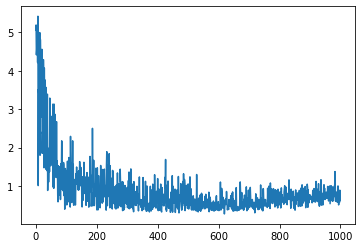

In [52]:
import matplotlib.pyplot as plt
no_nan = [float(x) for x in errors if not torch.isnan(x)]
plt.plot(no_nan[:1000]) 
plt.show()

In [57]:
latent_vec ## O not mixing into L. Need different transform.

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## scratch space

$x_1, X_2, X_3, \ldots, X_{p-1}, x_p = y$

$\beta_1^F, \beta_1^B, \beta_2^F, \beta_2^B, \ldots, \beta_{p-1}^F, \beta_{p-1}^B$

$\hat x_{j+1} = \sigma \left( \beta_j^{FT} x_j \right)$

forward series: $x_1, \hat x_2, \hat x_3, \ldots, \hat x_{p-1}, x_p = y$

$ \hat \beta_{p-1}^{FT} = \text{argmin}_\beta \| x_p - \beta^{T} \hat x_{p-1} \|^2 $

$ \hat \beta_{p-2}^{FT} = \text{argmin}_\beta \| \hat x_{p-1} - \beta^{T} \hat x_{p-2} \|^2 $ We won't do this. 

$ \tilde x_{j-1} = \sigma^{-1}\left( \beta_j^{BT} x_j \right)$

backward series: $x_1, \tilde x_2, \tilde x_3, \ldots, \tilde x_{p-1}, x_p = y$

$ \hat \beta_{p-2}^{F} = \text{argmin}_\beta \| \tilde x_{p-1} - \beta^{T} \hat x_{p-2} \|^2 $

$ \hat \beta_{p-2}^{B} = \text{argmin}_\beta \| \hat x_{p-2} - \beta^{T} \tilde x_{p-1} \|^2 $

$ \hat x_3 = \sigma \left( \beta_2^{FT} \hat x_2 \right) $

$ \hat \beta_2^F = \text{argmin}_\beta \| \sigma^{-1}\left( \hat x_3 \right) - \beta^T \hat x_2 \|^2 $ Useless without $\tilde x$

$ \tilde x_2 = \sigma^{-1}\left( \beta_3^{BT} \tilde x_3 \right) $

$ \hat \beta_2^B = \text{argmin}_\beta \| \sigma\left( \hat x_2 \right) - \beta^T \hat x_3 \|^2 $ Useless without $\hat x$

So, use these estimates instead.

$ \hat \beta_2^F = \text{argmin}_\beta \| \sigma^{-1}\left( \tilde x_3 \right) - \beta^T \hat x_2 \|^2 $

$ \hat \beta_2^B = \text{argmin}_\beta \| \sigma\left( \hat x_2 \right) - \beta^T \tilde x_3 \|^2 $

$\pi$